In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
DB5 = tokamakTK.clean_categorical_data(DB5)

In [5]:
# alpha_R -- 0.6358 --> when considering DB2 for calculation
data1 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)

# alpha_R -- 2.1560 --> when considering DB2 for calculation
data2 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)

# Removing DB2, because most of these shots have missing info
#data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1, data2]

In [6]:
# Needed for Improved Visualization: 2D and 3D Plots

HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
hue_order = HUEOrder(HUE_ORDER)

## IMPORTANT FEATURES

1. `RHOSTAR`: Normalized Ion Gyroradius
2. `NUSTAR`: Normalized Ion Collision Frequency
3. `Q95`: Plasma safety factor at the 95% poloidal flux surface
4. `BETASTAR`: normalized plasma beta
5. `BEIMHD`: Beta Shafranov

In [7]:
features = ['RHOSTAR', 'NUSTAR', 'Q95', 'BETASTAR', 'BEIMHD']

In [8]:
all_cases = [clean_numerical_data(data1[features+["DATE","TOK"]], SS_scaling=False, UL_scale=True),
             clean_numerical_data(data2[features+["DATE","TOK"]], SS_scaling=False, UL_scale=True)
            ]
Π = [get_pi_matrix(x, features, scale=False, intercept=False) for x in all_cases]

Condition index: [1.         1.9132849  2.19094533 4.91808782 7.42617271]
Condition index: [1.         2.25015625 2.78635201 4.88808565 7.46342132]


In [9]:
## GROUP 1 -- Decreasing alpha-R the most
print(f"\n\nDECREASING | size = {len(data1)}")
tokamakTK.get_general_insight(data1, DB5)



DECREASING | size = 1466
Missing Tokamaks: ['ASDEX' 'COMPASS' 'JFT2M' 'PBXM' 'PDX' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'D3D' 'JET' 'JETILW' 'JT60U' 'MAST' 'NSTX' 'START']


ELMTYPE
TYPE-1+2: 0.01
TYPE-1+5: 0.01
TYPE-I: 1.00
TYPE-II: 0.10
TYPE-III: 0.15
TYPE-RF: 0.00
TYPE-V: 0.03
UNKNOWN: 0.16


PHASE
HGELM: 1.00
HGELMH: 0.29
HSELM: 0.37
HSELMH: 0.03


In [10]:
## GROUP 2 -- Unaffected alpha-R
print(f"\n\nUNAFFECTED | size = {len(data2)}")
tokamakTK.get_general_insight(data2, DB5)



UNAFFECTED | size = 4786
Missing Tokamaks: []
Present Tokamaks: ['ASDEX' 'AUG' 'AUGW' 'CMOD' 'COMPASS' 'D3D' 'JET' 'JETILW' 'JFT2M'
 'JT60U' 'MAST' 'NSTX' 'PBXM' 'PDX' 'START' 'TCV' 'TDEV' 'TFTR']


ELMTYPE
TYPE-1+2: 0.01
TYPE-1+5: 0.00
TYPE-I: 1.00
TYPE-II: 0.06
TYPE-III: 0.10
TYPE-RF: 0.01
TYPE-V: 0.01
UNKNOWN: 0.43


PHASE
HGELM: 1.00
HGELMH: 0.24
HSELM: 0.48
HSELMH: 0.02


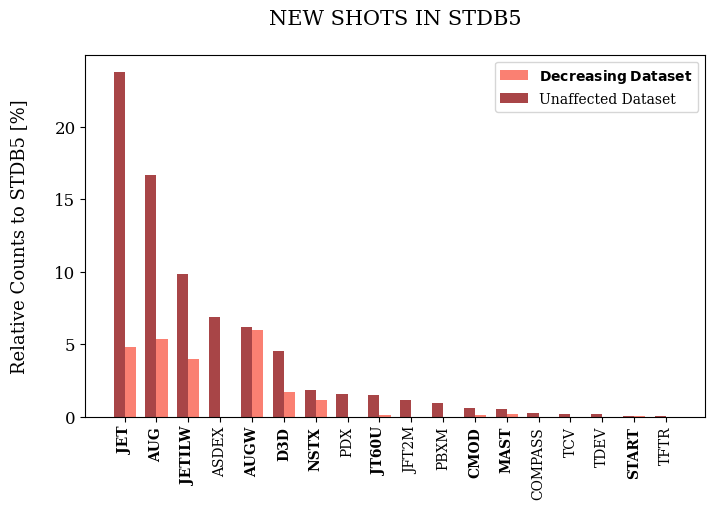

In [11]:
tokamakTK.plot_tok_comparison(data1, data2, DB5)

In [12]:
px.scatter_3d(
              data_frame=data1, x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="TOK", color_discrete_map=PX_ORDER["TOK"]
             )

In [13]:
px.scatter_3d(
              data_frame=data2, x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="TOK", color_discrete_map=PX_ORDER["TOK"]
             )

In [15]:
px.scatter_3d(
              data_frame=DB5, x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="label_6357", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [23]:
px.scatter_3d(
              data_frame=DB5[DB5.TOK.isin(['START','MAST','NSTX'])], x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="label_6357", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [24]:
px.scatter_3d(
              data_frame=DB5[DB5.TOK.isin(['START','MAST','NSTX'])], x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="label_9998", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [16]:
px.scatter_3d(
              data_frame=DB5, x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="label_9998", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [17]:
px.scatter_3d(
              data_frame=DB5, x="RHOSTAR", y="NUSTAR", z="Q95", 
              color="label_joe", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [18]:
px.scatter_3d(
              data_frame=DB5, x="RHOSTAR", y="NUSTAR", z="BETASTAR", 
              color="label_6357", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [19]:
px.scatter_3d(
              data_frame=DB5, x="RHOSTAR", y="NUSTAR", z="BETASTAR", 
              color="label_joe", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )